In [7]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

torch.Size([1, 1, 512, 512])


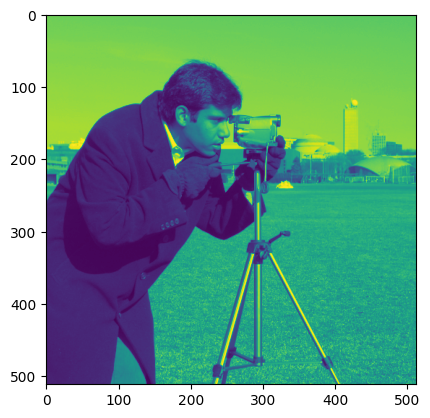

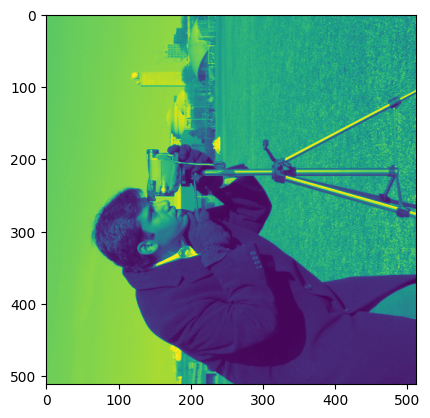

In [8]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import kornia as K
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from skimage import data

camera = K.image_to_tensor(data.camera(), keepdim=False)
camera = camera.float() / 255.
print(camera.shape)
timg = torch.cat([camera,torch.rot90(camera,1,dims=(2,3))], dim=0)
timg_gray = timg


plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

## Aumento de dados caminho de ida e volta e reprodutibilidade

In [9]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
            # kornia.augmentation.RandomEqualize(p=0.3),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result


def generate_random_points(image_size, num_points):
    # Extrair as dimensões da imagem
    H, W = image_size

    # Gerar tensores de coordenadas aleatórias
    random_coords = torch.rand(num_points, 2)

    # Dimensionar as coordenadas aleatórias de acordo com as dimensões da imagem
    random_coords[:, 0] *= W
    random_coords[:, 1] *= H

    return random_coords

In [10]:
import kornia

img1: torch.Tensor = kornia.image_to_tensor(data.camera(), keepdim=False).float() / 255.
input = torch.cat([img1,img1], dim=0)
B,C,H,W = input.shape
mask = torch.ones(B,C,H,W)
bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)

points = generate_random_points((H,W),60).expand(2, -1, -1)
print(points.shape)
shape = input.shape
params_lists =AugmentationParamsGenerator(6,shape)
next_item = next(params_lists)
print(next_item)


torch.Size([2, 60, 2])
[ParamItem(name='RandomAffine_0', data={'translations': tensor([], size=(0, 2)), 'center': tensor([], size=(0, 2)), 'scale': tensor([], size=(0, 2)), 'angle': tensor([]), 'shear_x': tensor([]), 'shear_y': tensor([]), 'batch_prob': tensor([0., 0.]), 'forward_input_shape': tensor([  2,   1, 512, 512])}), ParamItem(name='RandomPerspective_1', data={'start_points': tensor([[[  0.,   0.],
         [511.,   0.],
         [511., 511.],
         [  0., 511.]],

        [[  0.,   0.],
         [511.,   0.],
         [511., 511.],
         [  0., 511.]]]), 'end_points': tensor([[[ 14.5627,  14.0057],
         [499.4324,  24.7754],
         [502.4538, 495.1373],
         [ 10.0413, 487.1788]],

        [[ 14.5627,  14.0057],
         [499.4324,  24.7754],
         [502.4538, 495.1373],
         [ 10.0413, 487.1788]]]), 'batch_prob': tensor([1., 1.]), 'forward_input_shape': tensor([  2,   1, 512, 512])}), ParamItem(name='RandomBoxBlur_2', data={'batch_prob': tensor([1., 1.])

In [11]:
import matplotlib.pyplot as plt
import kornia

def plot_image_with_keypoints(image_tensor, keypoints_tensor):
    # Converter a imagem tensorial em objeto PIL.Image
    image = kornia.utils.tensor_to_image(image_tensor)
    # Plotar a imagem e os keypoints
    plt.imshow(image)
    if keypoints_tensor is not None:
        # Extrair as coordenadas x e y dos keypoints
        keypoints_x = keypoints_tensor[:,0].flatten().tolist()
        keypoints_y = keypoints_tensor[:,1].flatten().tolist()
        plt.scatter(keypoints_x, keypoints_y, c='red')
    plt.show()
    
def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        False  if not (0 <= ponto[0] <= dimensao_max_x 
                       and 0 <= ponto[1] <= dimensao_max_y 
                       and tensor_mascara[int(ponto[1]), int(ponto[0])]) else True
        for ponto in lista_de_pontos
    ]
    return torch.tensor(pontos_filtrados)

def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        ponto.tolist()  for ponto in lista_de_pontos 
        if 0 <= ponto[0] <= dimensao_max_x 
        and 0 <= ponto[1] <= dimensao_max_y 
        and tensor_mascara[int(ponto[1]), int(ponto[0])] 
    ]
    return torch.tensor(pontos_filtrados)

torch.Size([60, 2])


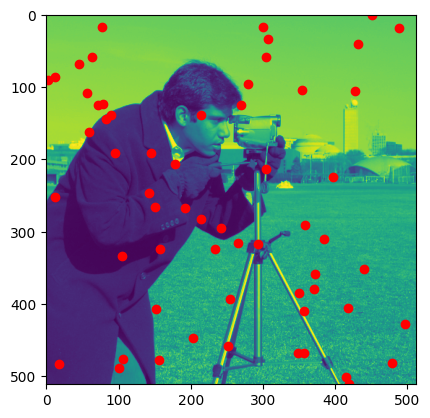

params_lists  6
torch.Size([60, 2]) torch.Size([512, 512])


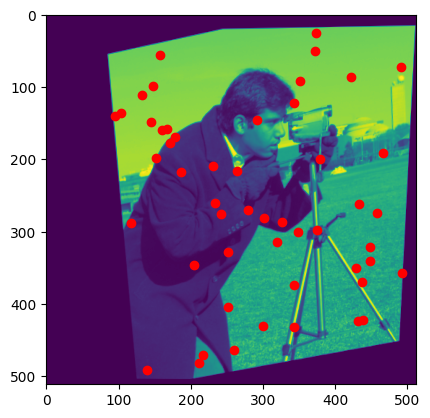

torch.Size([60, 2]) torch.Size([512, 512])


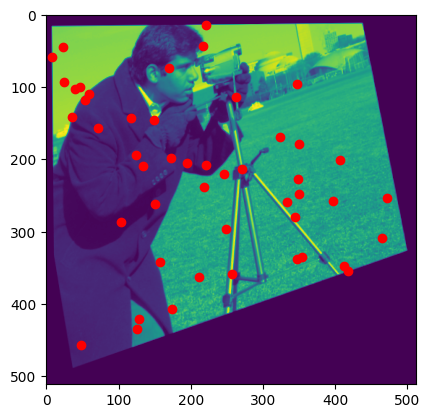

torch.Size([60, 2]) torch.Size([512, 512])


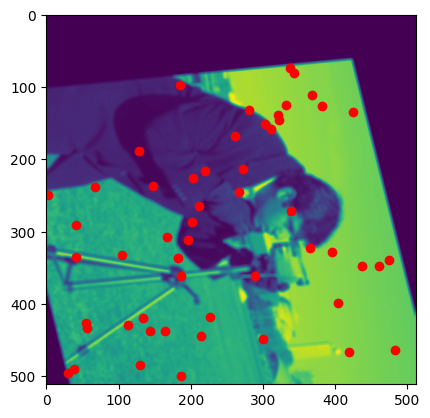

torch.Size([60, 2]) torch.Size([512, 512])


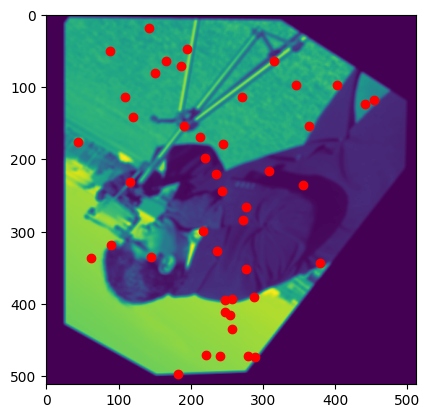

torch.Size([60, 2]) torch.Size([512, 512])


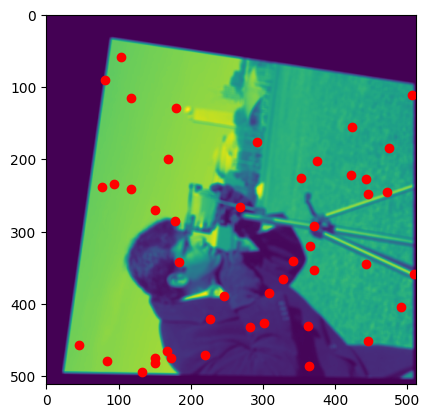

torch.Size([60, 2]) torch.Size([512, 512])


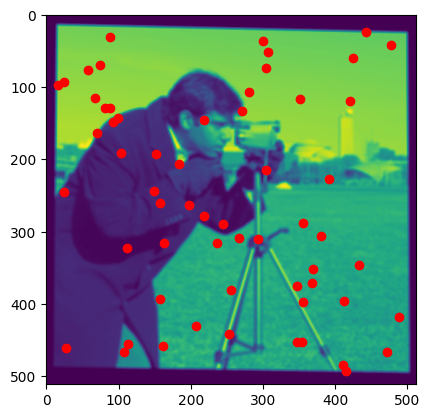

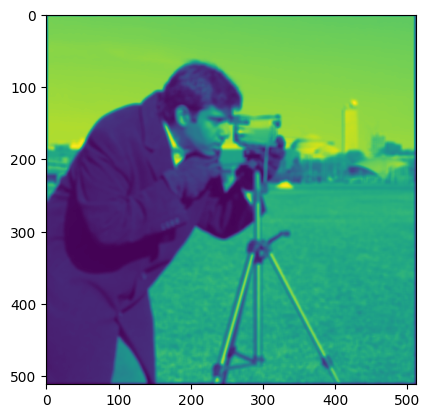

In [16]:
aug_list = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
    kornia.augmentation.RandomPerspective(0.1, p=0.7),
    kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

print(points[0].shape)
plot_image_with_keypoints(input[0],points[0])

print('params_lists ',len(params_lists.data))
for i in range(6):
    params_item = next(params_lists)
    out = aug_list(input, mask, bbox, points,params=params_item)
    print(out[3][0].shape,out[1][0,0].shape)
    filtered_points = filtrar_keypoints(out[3][0],out[1][0,0].bool())
    plot_image_with_keypoints(out[0][0],filtered_points)
    
out_inv = aug_list.inverse(*out)
plot_image_with_keypoints(out_inv[0][0],None)

torch.Size([60, 2])


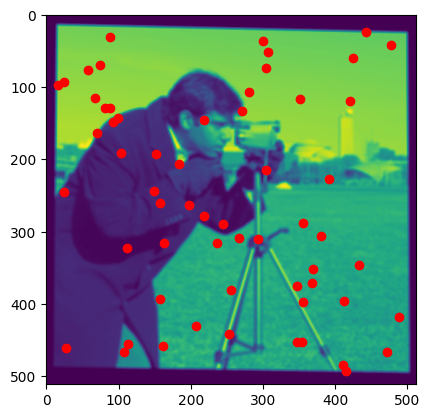

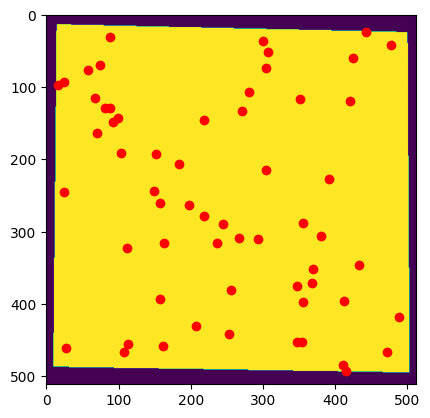

In [13]:
import torch

# Supondo que você tenha os dados de entrada
lista_de_pontos = out[3][0]
tensor_mascara = out[1][0, 0].bool()


# Filtrar keypoints
pontos_filtrados = filtrar_keypoints(lista_de_pontos, tensor_mascara)
print(pontos_filtrados.shape)
plot_image_with_keypoints(out[0][0],pontos_filtrados)
plot_image_with_keypoints(tensor_mascara,pontos_filtrados)

In [14]:
import numpy as np
from scipy.spatial.distance import cdist
def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched

#considerar correspondecia posicional
matches = find_best_matching_indices_knn(lista_de_pontos,pontos_filtrados,0.2)
len(matches),lista_de_pontos.shape,pontos_filtrados.shape

(60, torch.Size([60, 2]), torch.Size([60, 2]))

In [15]:
import torch

def calcular_momentos_imagem_canal(batch_tensor):
    # Obter as dimensões do batch_tensor
    B, C, H, W = batch_tensor.shape

    # Inicializar listas para armazenar os resultados
    medias = []
    maximos = []
    variancias = []
    assimetrias = []
    curtoses = []

    # Iterar sobre cada imagem do batch
    for b in range(B):
        # Iterar sobre cada canal de cor
        for c in range(C):
            # Obter a imagem atual (um canal de cor)
            imagem = batch_tensor[b, c]
            maximo = torch.max(imagem)
            # Calcular a média (primeiro momento)
            media = torch.mean(imagem)
            # Calcular a variância (segundo momento)
            variancia = torch.var(imagem)
            
            # Calcular a assimetria (terceiro momento)
            media_cubica = torch.mean((imagem - media) ** 3)
            desvio_cubico = torch.sqrt(variancia) ** 3
            assimetria = media_cubica / desvio_cubico

            # Calcular a curtose (quarto momento)
            media_quadrada = torch.mean((imagem - media) ** 4)
            curtose = media_quadrada / variancia ** 2

            # Armazenar os resultados para o canal atual
            medias.append(media.item())
            maximos.append(maximo.item())
            variancias.append(variancia.item())
            assimetrias.append(assimetria.item())
            curtoses.append(curtose.item())

    # Converter as listas para tensores
    medias = torch.tensor(medias).reshape(B, C)
    maximos = torch.tensor(maximos).reshape(B, C)
    variancias = torch.tensor(variancias).reshape(B, C)
    assimetrias = torch.tensor(assimetrias).reshape(B, C)
    curtoses = torch.tensor(curtoses).reshape(B, C)

    # Concatenar os tensores ao longo da dimensão C
    output_tensor = torch.cat((medias, maximos, variancias, assimetrias, curtoses), dim=1)

    return output_tensor

# Exemplo de uso:
# Suponha que 'batch_tensor' seja o seu tensor de imagens com a estrutura [B, C, 19, 19]
# Calcula os momentos para cada imagem e canal de cor
batch_tensor = torch.rand(4, 8, 19, 19)
output_tensor = calcular_momentos_imagem_canal(batch_tensor)

# Imprime o resultado como tensor
print("Saída:", output_tensor.shape)  # Saída esperada: torch.Size([4, 40])
print(output_tensor[0])


Saída: torch.Size([4, 40])
tensor([ 0.5065,  0.4984,  0.5120,  0.4755,  0.4899,  0.5030,  0.4869,  0.4847,
         0.9974,  0.9993,  0.9955,  0.9993,  0.9951,  0.9972,  0.9997,  0.9981,
         0.0899,  0.0774,  0.0806,  0.0810,  0.0838,  0.0823,  0.0862,  0.0843,
        -0.0749,  0.0409, -0.0524,  0.1120, -0.0038, -0.0045,  0.0319,  0.0307,
         1.6870,  1.8770,  1.7876,  1.8969,  1.7496,  1.7234,  1.7188,  1.7944])
